## Exploratory Data Analysis / Feature Extraction

In [1]:
from os import walk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# parse the file names into a numpy matrix, each row represents one file.
RAW_DATA_PATH = '../data/raw'
dirs = []
for (dirpath, dirnames, _) in walk(RAW_DATA_PATH):
    for d in dirnames:
        if d.startswith("Actor"):
            dirs.append(dirpath+'/'+d)
    break
    
all_files = []
for actor in dirs:
    for(_,_,files) in walk(actor):
        all_files+=[i.split('.')[0].split('-') for i in files]
        break
all_files = [[int(i) - 1 for i in row] for row in all_files]

files = np.array(all_files)
print(files)

[[ 2  0  4 ...  1  0 15]
 [ 2  0  5 ...  1  1 15]
 [ 2  0  5 ...  0  1 15]
 ...
 [ 2  0  1 ...  0  0  7]
 [ 2  0  1 ...  1  0  7]
 [ 2  0  0 ...  1  1  7]]


In [3]:
def matrix_to_filename(matrix, RAW_DATA_PATH):
    filepaths = []
    for row in matrix:
        filename = ''
        for col in row:
            filename+=str(col+1).zfill(2)
            filename+='-'
        filename = filename[:-1]
        filename+='.wav'
        filepaths.append(RAW_DATA_PATH+'/Actor_'+str(row[6]+1).zfill(2)+'/'+filename)
        # print(filename)
    return filepaths
def plot_counts(files):
    print(f"Total number of files {files.shape[0]}")

    labels = [['full-AV', 'video-only', 'audio-only'],
             ['speech', 'song'],
             ['neutral' , 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust','surprised'],
             ['normal', 'strong'],
             ['Kids are talking by the door', 'Dogs are sitting by the door'],
             ['1st repetition', '2nd repetition'],
             ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
             ]
    titles = ['Modality', 'Vocal channel', 'Emotion', 'Emotional intensity' ,'Statement','Repetition' ,'Actor']
    
    fig, ax = plt.subplots(2, 4, figsize=(20, 10)) 
    inds = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]
    for i in range(7):
        unique, counts = np.unique(files[:, i], return_counts = True)
        unique = np.array(labels[i])[unique]
        ax[inds[i]].bar(unique, counts)
        ax[inds[i]].set_title(titles[i])
    ax[inds[-1]].axis('off')
    plt.suptitle("Count Plots")
    plt.tight_layout()
    plt.show()

Total number of files 1440


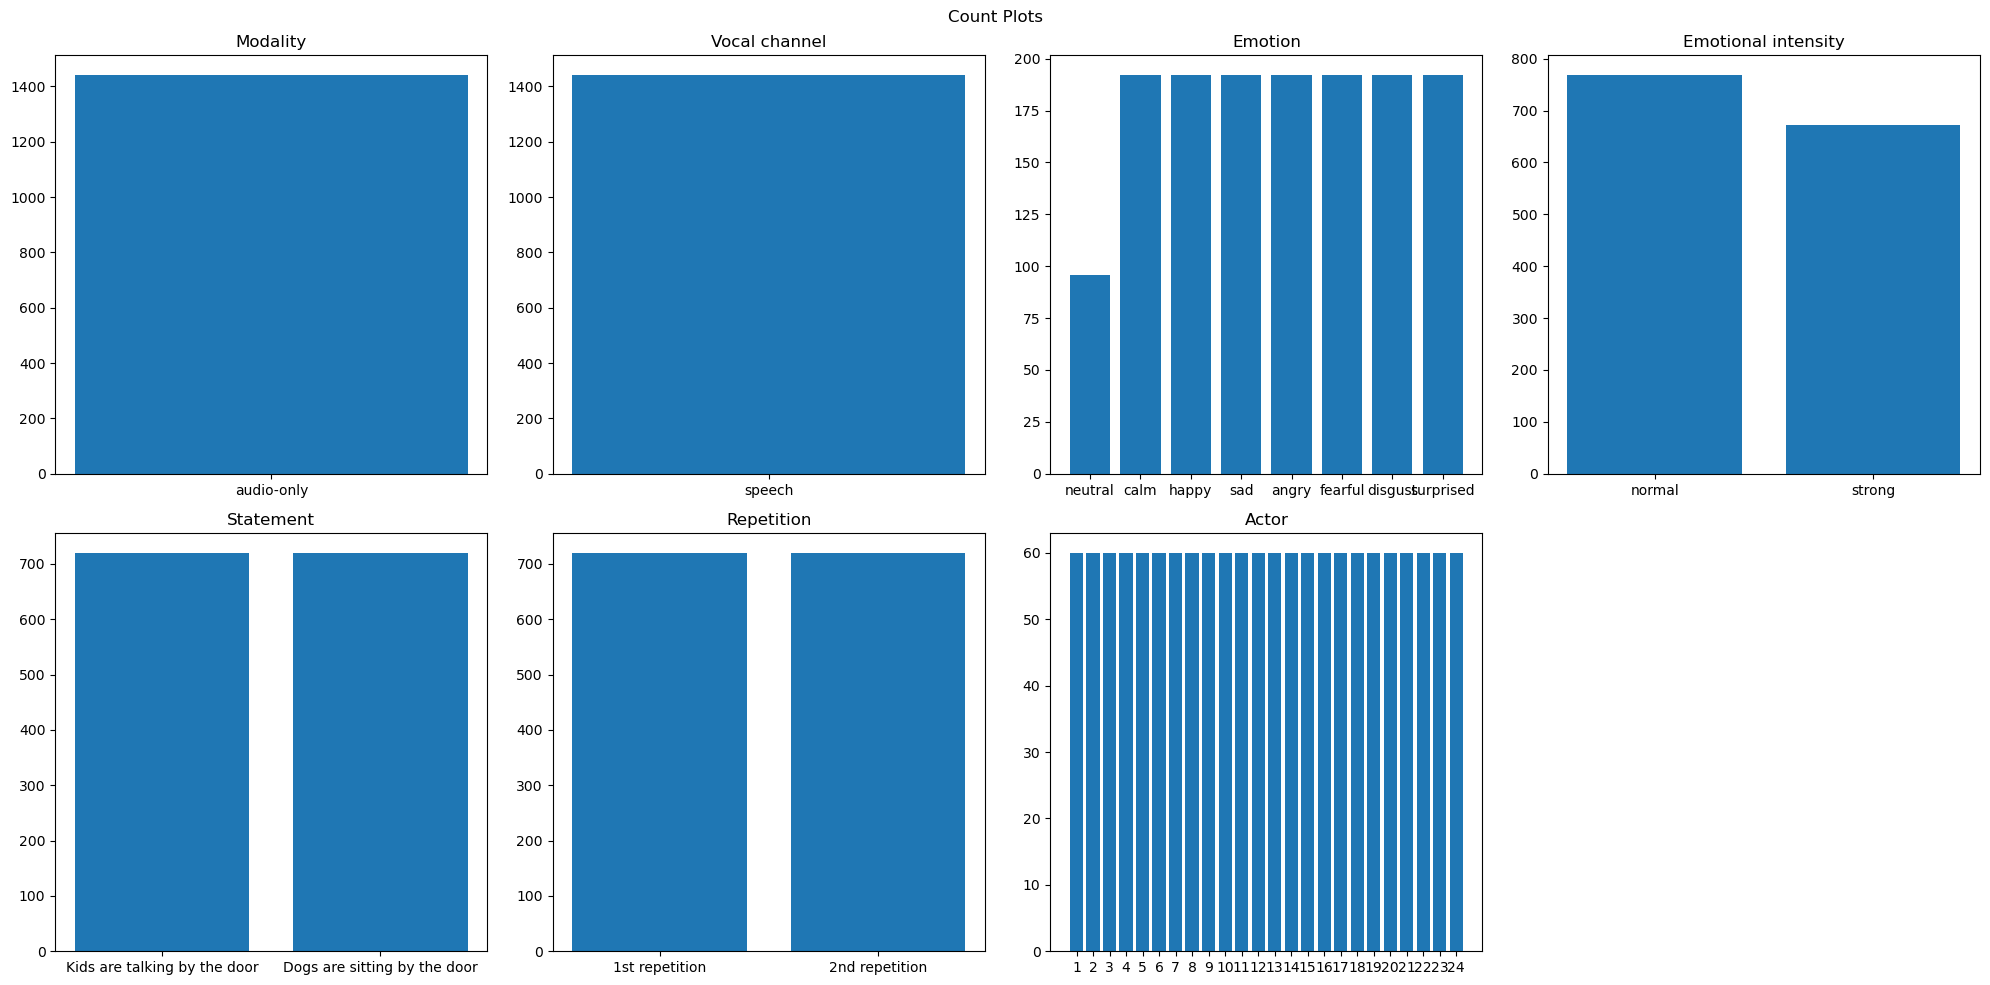

In [4]:
plot_counts(files)

Total number of files 96


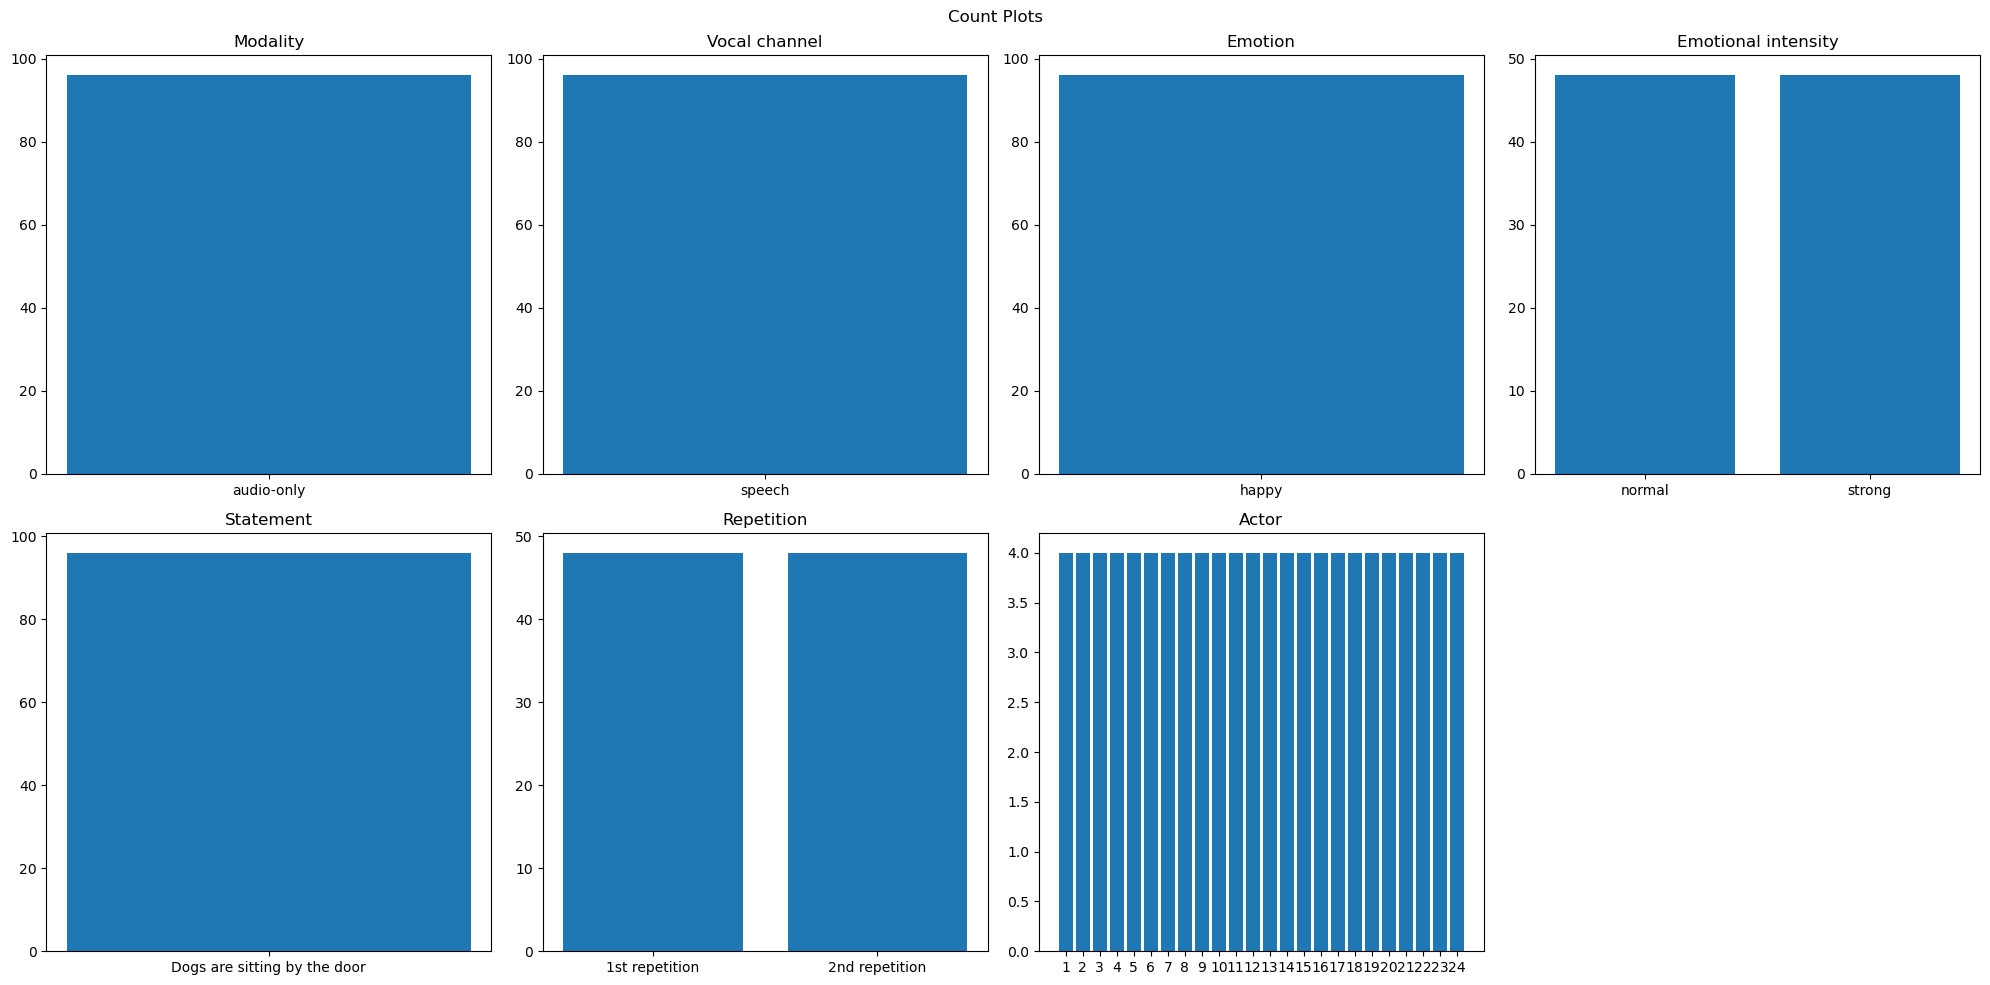

In [5]:
# plot only happy files with "dogs are sitting by the door"
mask = (files[:, 2] == 2 )
mask2 = (files[:, 4] == 1 )
extracted = files[mask&mask2]
plot_counts(extracted)

In [6]:
# average audio of all happy saying "dogs are sitting by the door"
#! pip install librosa
import librosa 
import librosa.display
from IPython.display import Audio, Image, display

filepaths = matrix_to_filename(extracted, RAW_DATA_PATH)
all_samples = []
for file in filepaths:
    samples, sample_rate = librosa.load(file, sr=None)
    all_samples.append(samples)

mn = min(len(row) for row in all_samples)
print(mn)

truncated_data = [row[:mn] for row in all_samples]
average_audio = np.mean(np.array(truncated_data), axis = 0)
Audio(data=average_audio, rate=48000)



150551


In [7]:
len(all_samples)

96

### Todo
Mel-Frequency Cepstral Coefficients (MFCC) - Short term power spectrum of sound, divides frequencies based on mel scale over time.

Wav2Vec - Open source model by Meta AI,  self supervised learning of speech representations from audio data

Zero Crossing Rate - Number of times a sound wave crosses the x-axis

Root Mean Square  - Measuring average power of a sound signal over time

Spectral Centroid - Amplitude weighted mean of signal frequencies

Spectral Rolloff - Frequency below which 99% of the energy lies under


### Spectral Centroid

In [8]:
import pandas as pd
import numpy as np
import librosa
import os

In [9]:
frame_size = 1024
hop_ength = 512

In [10]:
all_filepaths = matrix_to_filename(files, RAW_DATA_PATH) 
len(all_filepaths) # 1440


1440

In [11]:

import pandas as pd
import numpy as np
df = pd.DataFrame(columns=[
    'Modality',
    'Vocal_channel',
    'Emotion',
    'Emotional_intensity',
    'Statement',
    'Repetition',
    'Actor',
    'Centroid_mean',
    'Centroid_std'
    ])

for i, filepath in enumerate(all_filepaths):
    arr = files[i]
    y, sr = librosa.load(filepath)
    sc_y = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_size, hop_length=hop_ength)[0]
    centoid_mean = np.mean(sc_y)
    centoid_std = np.std(sc_y)
    arr = np.append(arr, [centoid_mean, centoid_std])
    df.loc[len(df)] = arr
    
df.describe()


,Modality,Vocal_channel,Emotion,Emotional_intensity,Statement,Repetition,Actor,Centroid_mean,Centroid_std
count,1440.0,1440.0,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,2.0,0.0,3.733333,0.466667,0.500000,0.500000,11.500000,2846.219801,1531.155978
std,0.0,0.0,2.175356,0.499061,0.500174,0.500174,6.924591,368.884789,294.729251
min,2.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1682.472070,849.937005
25%,2.0,0.0,2.000000,0.000000,0.000000,0.000000,5.750000,2590.950729,1314.894522
50%,2.0,0.0,4.000000,0.000000,0.500000,0.500000,11.500000,2842.380079,1498.425810
75%,2.0,0.0,6.000000,1.000000,1.000000,1.000000,17.250000,3116.793774,1739.894517
max,2.0,0.0,7.000000,1.000000,1.000000,1.000000,23.000000,3869.406987,2328.852285


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1439
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Modality             1440 non-null   float64
 1   Vocal_channel        1440 non-null   float64
 2   Emotion              1440 non-null   float64
 3   Emotional_intensity  1440 non-null   float64
 4   Statement            1440 non-null   float64
 5   Repetition           1440 non-null   float64
 6   Actor                1440 non-null   float64
 7   Centroid_mean        1440 non-null   float64
 8   Centroid_std         1440 non-null   float64
dtypes: float64(9)
memory usage: 112.5 KB


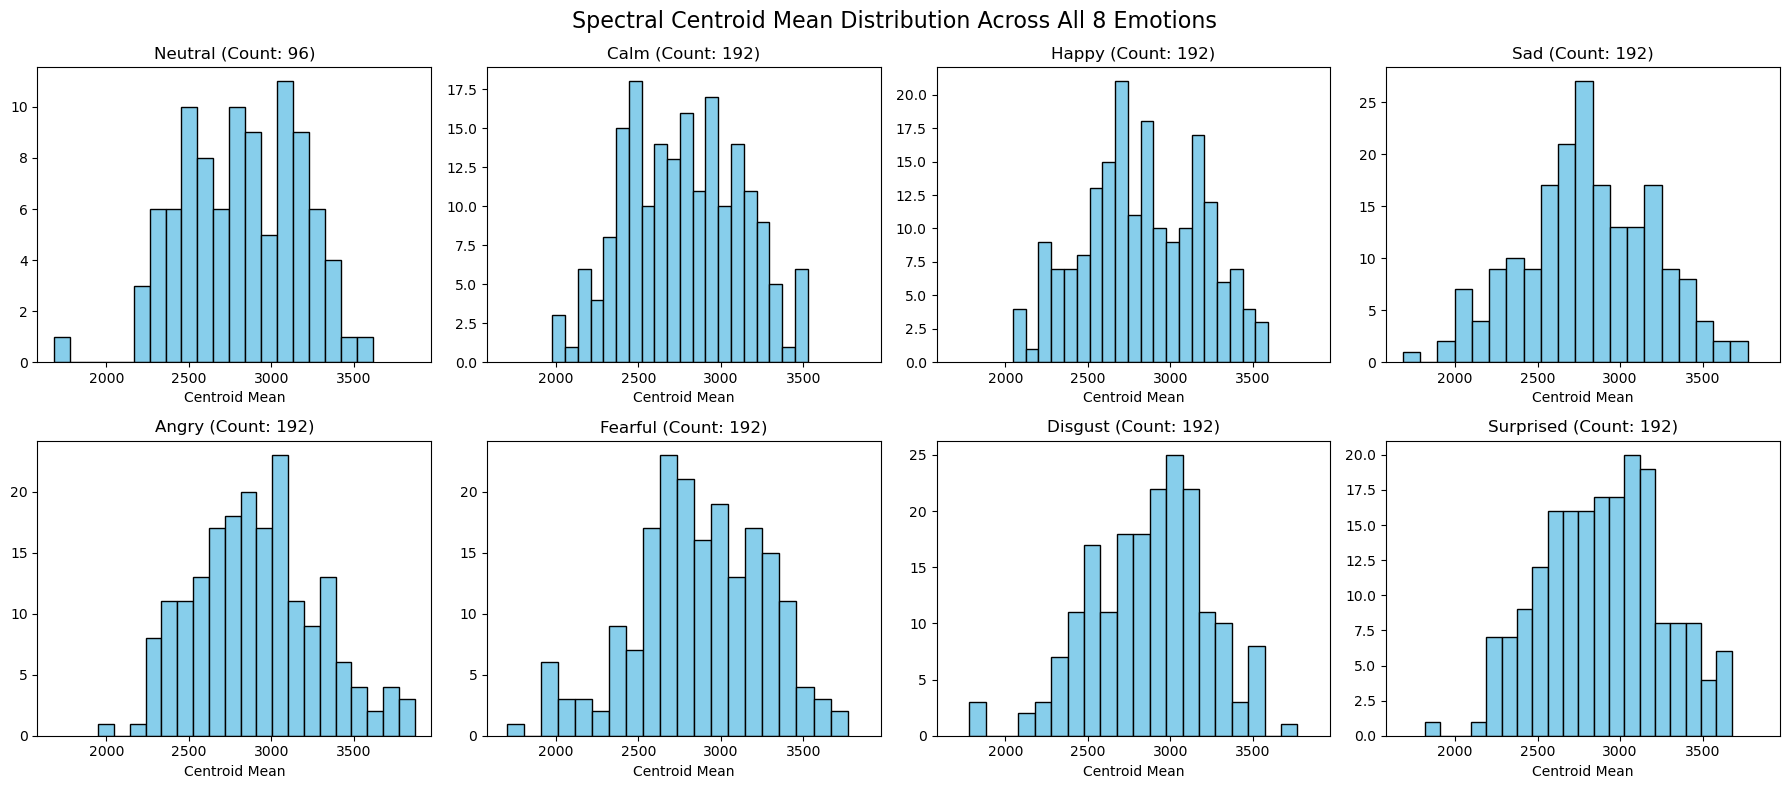

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten() 

emotion_dict = {
    0: 'Neutral', 1: 'Calm', 2: 'Happy', 3: 'Sad',
    4: 'Angry', 5: 'Fearful', 6: 'Disgust', 7: 'Surprised'
}

emotions = sorted(df['Emotion'].unique())

for i, emotion in enumerate(emotions):
    subset = df[df['Emotion'] == emotion]
    
    emotion_label = emotion_dict.get(emotion)
    
    axes[i].hist(
        subset['Centroid_mean'], 
        bins=20,                    
        edgecolor='black', 
        color='skyblue'            
    )
    
    axes[i].set_title(f'{emotion_label} (Count: {len(subset)})', fontsize=12)
    
    x_min = df['Centroid_mean'].min()
    x_max = df['Centroid_mean'].max()
    axes[i].set_xlim(x_min-100, x_max+100)
    
    axes[i].set_xlabel('Centroid Mean')
    
fig.suptitle('Spectral Centroid Mean Distribution Across All 8 Emotions', fontsize=16)
plt.tight_layout() 
plt.show()

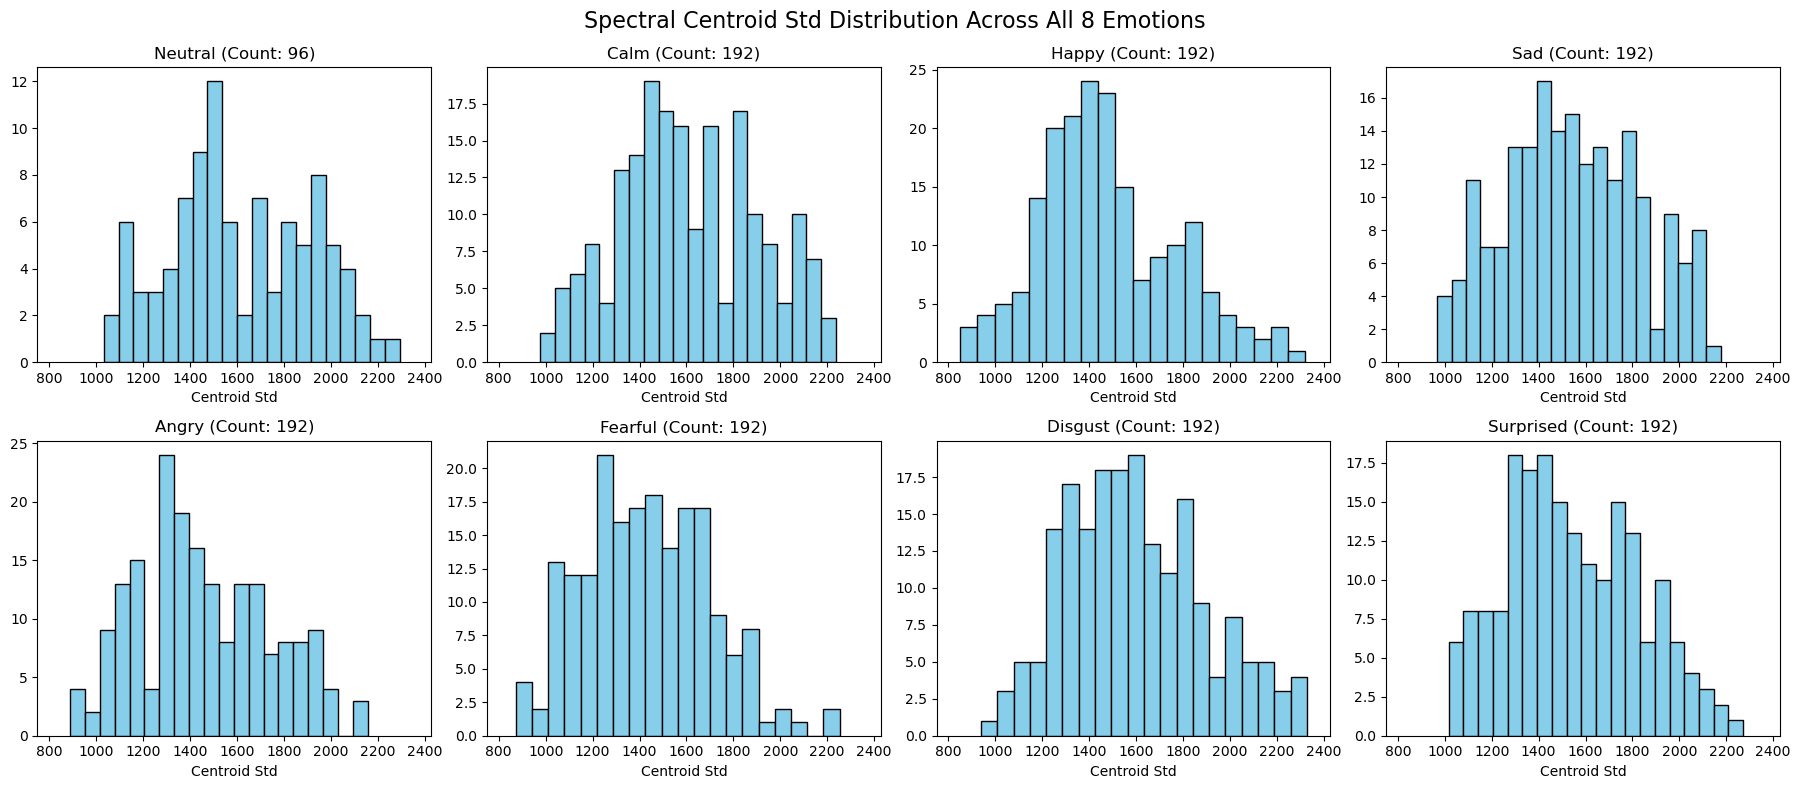

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten() 

emotion_dict = {
    0: 'Neutral', 1: 'Calm', 2: 'Happy', 3: 'Sad',
    4: 'Angry', 5: 'Fearful', 6: 'Disgust', 7: 'Surprised'
}

emotions = sorted(df['Emotion'].unique())

for i, emotion in enumerate(emotions):
    subset = df[df['Emotion'] == emotion]
    
    emotion_label = emotion_dict.get(emotion)
    
    axes[i].hist(
        subset['Centroid_std'], 
        bins=20,                    
        edgecolor='black', 
        color='skyblue'            
    )
    
    axes[i].set_title(f'{emotion_label} (Count: {len(subset)})', fontsize=12)
    
    x_min = df['Centroid_std'].min()
    x_max = df['Centroid_std'].max()
    axes[i].set_xlim(x_min-100, x_max+100)
    
    axes[i].set_xlabel('Centroid Std')
    
fig.suptitle('Spectral Centroid Std Distribution Across All 8 Emotions', fontsize=16)
plt.tight_layout() 
plt.show()

### MFCC

In [32]:
def extract_mfcc(file_path, n_mfcc=40, max_len=400):
    """
    Extracts a CNN-ready MFCC matrix from an audio file.
    Output shape: (n_mfcc, max_len)
    """

    x, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)

    #  CNN expects every sample to have the same length
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    else:
        mfcc = mfcc[:, :max_len]

    return mfcc


In [33]:
all_mfcc = []
for path in all_filepaths:
    mfcc = extract_mfcc(path)
    all_mfcc.append(mfcc)

all_mfcc = np.array(all_mfcc)
all_mfcc.shape

(1440, 40, 400)

In [47]:
all_files[0:10]
all_labels = np.array(all_files)   
emotion_labels = all_labels[:, 2]  
actor_labels = all_labels[:, 6]

In [39]:
emotion_labels.shape

(1440,)

In [40]:
X = all_mfcc  
y = emotion_labels 


In [53]:
from sklearn.model_selection import train_test_split


unique_actors = np.sort(np.unique(actor_labels)) 

# Train-Validation-Test split
train_actors = unique_actors[:18]    # Actors 1-18 (IDs 0-17)
val_actors = unique_actors[18:21]    # Actors 19-21 (IDs 18-20)
test_actors = unique_actors[21:]     # Actors 22-24 (IDs 21-23)


train_mask = np.isin(actor_labels, train_actors)
val_mask = np.isin(actor_labels, val_actors)
test_mask = np.isin(actor_labels, test_actors)


# X_train, y_train
X_train = X[train_mask]
y_train = y[train_mask]

# X_val, y_val
X_val = X[val_mask]
y_val = y[val_mask]

# X_test, y_test
X_test = X[test_mask]
y_test = y[test_mask]

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(1080, 40, 400) (1080,)
(180, 40, 400) (180,)
(180, 40, 400) (180,)


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [71]:
import torch
from torch.utils.data import Dataset

class MFCCDataset(Dataset):
    """
    Simple Dataset for MFCC features stored in memory as numpy arrays.
    Expects:
      X: numpy array shape (N, n_mfcc, time_frames)
      y: numpy array shape (N,) of integer labels, or None for unlabeled data
      transform: optional callable applied to the raw numpy (n_mfcc, time) array
    Returns:
      x_tensor: torch.FloatTensor shape (1, n_mfcc, time)
      y_tensor: torch.LongTensor scalar (if y provided)
    """
    def __init__(self, X, y=None, transform=None):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.transform = transform
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # get sample (n_mfcc, time)
        x = self.X[idx]

        # optional transform (data augmentation / normalization)
        if self.transform is not None:
            x = self.transform(x)

        # add channel dimension -> (1, n_mfcc, time)
        x = np.expand_dims(x, axis=0)

        # to tensor
        x_tensor = torch.from_numpy(x)        # dtype=torch.float32

        y_tensor = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x_tensor, y_tensor


In [72]:
from torch.utils.data import DataLoader

# Instantiate the three Datasets
train_dataset = MFCCDataset(X=X_train, y=y_train)
val_dataset = MFCCDataset(X=X_val, y=y_val)
test_dataset = MFCCDataset(X=X_test, y=y_test)

# Instantiate DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNEmotionClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (16, 40, 400)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)        # (16, 20, 200)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # (32, 20, 200)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)        # (32, 10, 100)
        )

        # flatten size = 32 * 10 * 100 = 32000
        self.fc = nn.Sequential(
            nn.Linear(32 * 10 * 100, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
 
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        x = x.view(x.size(0), -1)

        output = self.fc(x)
        return output

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNEmotionClassifier(num_classes=8).to(device)
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [75]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(X)

        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


In [76]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)
            loss = loss_fn(outputs, y)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)

            correct += (predicted == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


In [77]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


In [78]:
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, loss_fn, optimizer, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, loss_fn, device
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")


Epoch 1/20: Train Loss=9.2666, Train Acc=0.1630 | Val Loss=2.0040, Val Acc=0.1722
Epoch 2/20: Train Loss=1.9205, Train Acc=0.2083 | Val Loss=1.9600, Val Acc=0.2722
Epoch 3/20: Train Loss=1.7684, Train Acc=0.2880 | Val Loss=1.9073, Val Acc=0.3056
Epoch 4/20: Train Loss=1.6308, Train Acc=0.3194 | Val Loss=1.9302, Val Acc=0.2833
Epoch 5/20: Train Loss=1.5576, Train Acc=0.3491 | Val Loss=1.8763, Val Acc=0.3500
Epoch 6/20: Train Loss=1.4922, Train Acc=0.3435 | Val Loss=1.8412, Val Acc=0.3167
Epoch 7/20: Train Loss=1.3833, Train Acc=0.4102 | Val Loss=1.9600, Val Acc=0.3611
Epoch 8/20: Train Loss=1.2658, Train Acc=0.4676 | Val Loss=1.8918, Val Acc=0.3944
Epoch 9/20: Train Loss=1.2234, Train Acc=0.4602 | Val Loss=1.9068, Val Acc=0.3944
Epoch 10/20: Train Loss=1.1293, Train Acc=0.5231 | Val Loss=2.0099, Val Acc=0.4444
Epoch 11/20: Train Loss=1.0303, Train Acc=0.5426 | Val Loss=1.9607, Val Acc=0.4556
Epoch 12/20: Train Loss=0.9503, Train Acc=0.5824 | Val Loss=2.0439, Val Acc=0.4778
Epoch 13/20: 

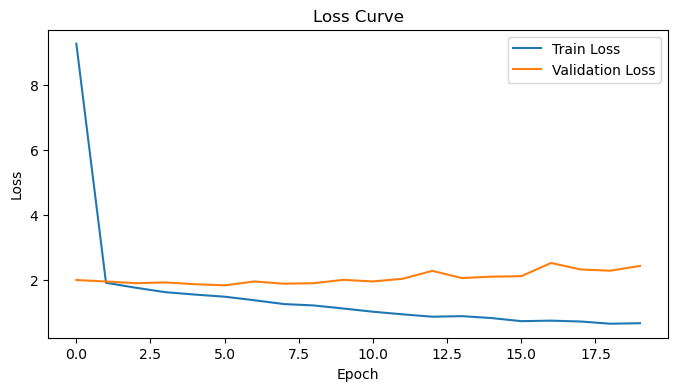

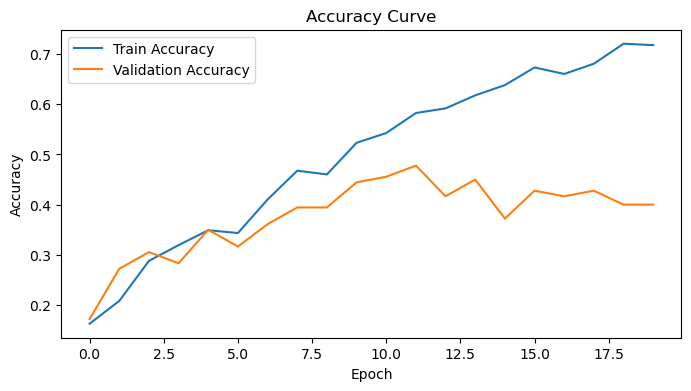

In [79]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(8,4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()


In [81]:
torch.save(model.state_dict(), "ravdess_cnn.pth")
model = CNNEmotionClassifier() 
model.load_state_dict(torch.load("ravdess_cnn.pth"))
model.to(device)
model.eval()


CNNEmotionClassifier(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=32000, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=8, bias=True)
  )
)

In [82]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
print(f"Test Loss={test_loss:.4f}, Test Accuracy={test_acc:.4f}")


Test Loss=2.2474, Test Accuracy=0.2889


In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())


<Figure size 800x800 with 0 Axes>

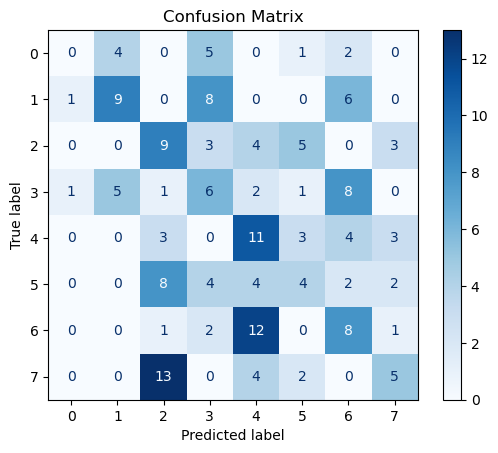

In [86]:
plt.figure(figsize=(8, 8))  

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")     

plt.title("Confusion Matrix")
plt.show()
